# Clustering (K-means, PCA, and LDA)

PCA and other clustering methods can be characterized as representing high-dimensional data (PCA, LDA) or just a lot of data (k-means) in terms of some intrinsic dimensions.

In the simplest case, imagine that we wanted to take a video of a mouse running back and forth in a tube (where it could only turn around and go in the other direction) but someone bumped the camera so that it was tilted at a certain angle to the horizon (x1), theta. If we used the raw data, we would see that the mouse moved in both the x1 (left/right) and x2 (up/down) dimensions. However, if we properly rotate our point of view (by -theta), we can see that the mouse only moves along one dimension (left/right or up/down).

That is the goal of PCA, to rotate our multidimensional "camera" such that we eliminate as many superfluous dimensions as possible. In the general case, we would have noisy data. So, rotating it would not completely eliminate data in some dimensions, but rather just minimize the variance in the more superfluous dimensions and maximize it on the important ones, where there is a lot of variability. Thus PCA, assuming it is successful, is a powerful tool for preprocessing your data and data compression.

In [18]:
# A bunch of imports in no particular order...
%matplotlib inline
import sklearn.datasets as ds
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA, FastICA
import sklearn.metrics as met

import sklearn.cluster as cl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
import numpy as np

In this demo we're going to look at a few nuances of PCA and a few common applications. There is no concrete rule on when and how you should apply PCA. As the data scientist using these techniques, it is your responsibility to understand how and when to deploy these techniques.

First, we'll start off with a comparison of PCA and LDA. To do so we need to write data generation and visualization functions.

In [2]:
def create_data_cloud(n, m1, m2, cov1, cov2):
    # create 3d data cloud of two multivariate gaussians
    ds1 = np.random.multivariate_normal(m1, cov1, n)
    ds2 = np.random.multivariate_normal(m2, cov2, n)
    labels = np.hstack([np.zeros(n), np.ones(n)])
    return np.vstack([ds1, ds2]), labels


# a flexible function that plots 3d maps
def plot3D(ds=None, labels=None, comp=None, fig=None, axloc=111, xlim=[-4,4], 
           ylim=[-4,4], zlim=[-4,4], xc=5, yc=5, zc=5):    
    if fig is None:
        fig = plt.figure()
    ax = fig.add_subplot(axloc, projection='3d')
    colors = ('red', 'blue', 'green', 'yellow', 'cyan', 'black', 'purple', 'gray')
    cmap = ListedColormap(colors[:len(np.unique(labels))])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_zlim(zlim)
    if ds is not None:
        if labels is not None:
            ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], marker='.', 
                       alpha=1, lw=0, c=cmap(labels))
        else:
            ax.scatter(ds[:, 0], ds[:, 1], ds[:, 2], marker='.', 
                       alpha=1, lw=0)
    
    if comp is not None:
        # add principal components here:
        for i in np.arange(len(comp)):
            ax.plot([-xc*comp[i, 0], xc*comp[i, 0]],
                    [-yc*comp[i, 1], yc*comp[i, 1]],
                    zs=[-zc*comp[i, 2], zc*comp[i, 2]])

    return fig, ax

(<matplotlib.figure.Figure at 0x7f01f6a5de48>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f01f6a3edd8>)

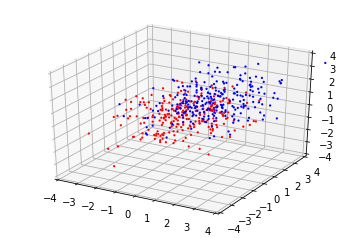

In [3]:
# generate random data. Feel free to modify
n = 250
m1 = np.array([0, 0, 0])
m2 = np.array([1, 1, 1])
cov1 = np.array([[1, .9, .1],
                 [.9, 1, .2],
                 [.1, .2, 1]])
cov2 = cov1 
x, y = create_data_cloud(n, m1, m2, cov1, cov2)
plot3D(x, y)

Silhouette score: 0.37004102118477517


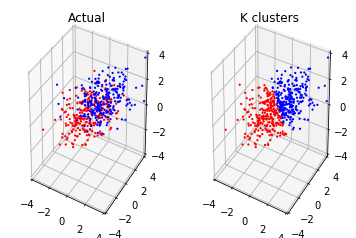

In [22]:
# Let's run K-means on this just to show how it is called

km = cl.KMeans(n_clusters=2)
km.fit(x)
pred = km.predict(x)
# equivalent to running .fit_predict(x)

f = plt.figure()
f, ax = plot3D(x, y, fig=f, axloc=121)
ax.set_title("Actual")
f, ax = plot3D(x, pred, fig=f, axloc=122)
ax.set_title("K clusters")

sil_score = met.silhouette_score(x, pred)  # silhouette score implemented in sklearn
print("Silhouette score: {}".format(sil_score))

In scikit-learn, PCA is easy to implement. It uses a .fit() and .transform() function to either calculate the rotations or apply them to new data. The principal components themselves are stored in .components_.

Text(0.5,1,'Variance explained')

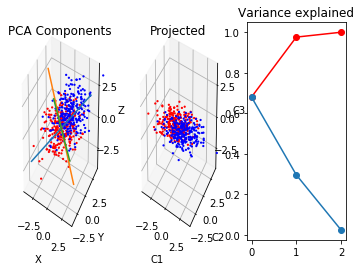

In [5]:
pca = PCA()
x_pca = pca.fit_transform(x)
f = plt.figure(figsize=(9, 27))
f, ax = plot3D(x, y, pca.components_, axloc=131)
ax.set_title('PCA Components')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


f, ax = plot3D(x_pca, y, fig=f, axloc=132)
ax.set_title('Projected')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

# aka Scree plot
ax = f.add_subplot(133)
ax.plot(np.cumsum(pca.explained_variance_ratio_), 'ro-')
ax.plot(pca.explained_variance_ratio_, 'o-')
ax.set_title("Variance explained")

Text(0.5,1,'Projected')

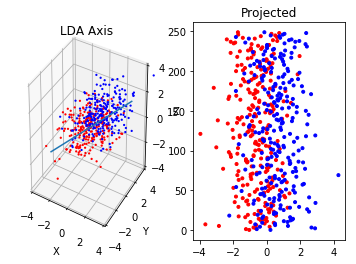

In [6]:
lda = LinearDiscriminantAnalysis()
x_lda = lda.fit_transform(x, y)
f, ax = plot3D(x, y, lda.coef_, axloc=121)
ax.set_title('LDA Axis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


colors = ('red', 'blue', 'green', 'yellow', 'cyan', 'black', 'purple', 'gray')
cmap = ListedColormap(colors[:len(np.unique(y))])
ax =f.add_subplot(122)
ax.scatter(np.squeeze(x_lda), 
           np.hstack([np.arange(len(y)/2), np.arange(len(y)/2)]), 
           c=cmap(y), marker='.')
ax.set_title('Projected')


(array([ 5., 12., 25., 55., 70., 45., 23., 14.,  0.,  1.]),
 array([-2.23509083, -1.5857517 , -0.93641257, -0.28707345,  0.36226568,
         1.01160481,  1.66094394,  2.31028307,  2.9596222 ,  3.60896133,
         4.25830045]),
 <a list of 10 Patch objects>)

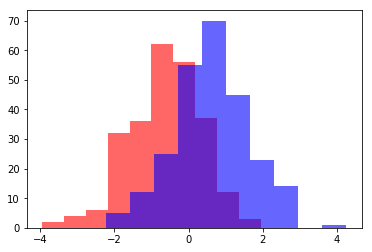

In [7]:
plt.hist(x_lda[y==0], alpha=0.6, color='r')
plt.hist(x_lda[y==1], alpha=0.6, color='b')

(array([ 8., 10., 33., 64., 64., 37., 28.,  5.,  0.,  1.]),
 array([-3.20893453, -2.25033974, -1.29174495, -0.33315016,  0.62544463,
         1.58403941,  2.5426342 ,  3.50122899,  4.45982378,  5.41841857,
         6.37701336]),
 <a list of 10 Patch objects>)

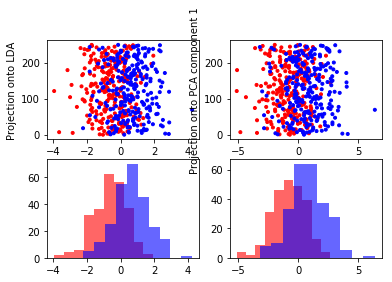

In [8]:
colors = ('red', 'blue', 'green', 'yellow', 'cyan', 'black', 'purple', 'gray')
cmap = ListedColormap(colors[:len(np.unique(y))])

f = plt.figure()
ax = f.add_subplot(221)

ax.scatter(np.squeeze(x_lda), 
           np.hstack([np.arange(len(y)/2), np.arange(len(y)/2)]), 
           c=cmap(y), marker='.')
ax.set_ylabel('Projection onto LDA')

ax = f.add_subplot(223)
ax.hist(x_lda[y==0], alpha=0.6, color='r')
ax.hist(x_lda[y==1], alpha=0.6, color='b')


ax = f.add_subplot(222)
ax.scatter(np.squeeze(x_pca[:,0]), 
           np.hstack([np.arange(len(y)/2), np.arange(len(y)/2)]), 
           c=cmap(y), marker='.')
ax.set_ylabel('Projection onto PCA component 1')

ax = f.add_subplot(224)
ax.hist(x_pca[y==0, 0], alpha=0.6, color='r')
ax.hist(x_pca[y==1, 0], alpha=0.6, color='b')

To really get into exploring PCA, we need to work in a high dimensional space.

Let's create a classification dataset in which there are some informative and uninformative features.

In [9]:
x, y = ds.make_classification(n_features=100, n_informative=50, n_redundant=0, random_state=42, n_clusters_per_class=1)

In [10]:
def x_summary(x):
    plt.subplot2grid((2,2), (0,0), colspan=1, rowspan=2)
    plt.imshow(x)
    plt.title('X')
    plt.subplot2grid((2,2), (0,1))
    plt.imshow(np.cov(x))
    plt.ylabel('Sample covariance')
    plt.subplot2grid((2,2), (1,1))
    plt.imshow(np.cov(x.T))
    plt.ylabel('Feature covariance')

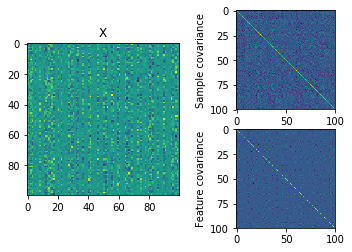

In [11]:
x_summary(x)

By visual inspection, it's hard to see whether features are correlated, informative, or uninformative. PCA is a useful diagnostic tool for understanding the importance of features. One way we can inspect the intrinsic dimensions is to look at the proportion of variance explained by all principal components.

(100, 100) (100, 100)


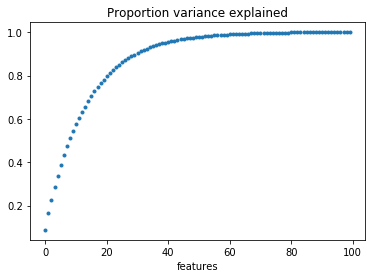

In [12]:
pca = PCA()
X_pca = pca.fit_transform(x)

plt.plot(np.cumsum(pca.explained_variance_ratio_), '.')
plt.title("Proportion variance explained")
plt.xlabel("features")
print(x.shape, X_pca.shape)

As we can see, 50 components are roughly enough to explain all of the variation in our dataset. The case can even be made that around 20-40 components, we see diminishing returns by including more components.

## Data reconstruction

The principal components represent linear combinations of the features that explain variance together. If we decide that a principal component is not useful, we can just choose to ignore it (fortunately they are arranged by order of most explanatory to least). 

Because of this, we can "reconstruct" our data using only the meaningful principal components. For example, we found that 50 components was sufficient to explain the majority of the variance on the x dataset, and thus conclude that the latter 50 components are capturing noise-related variance. We can very quickly reconstruct our original data by using the inverse_transform() method. 

By removing uninformative components, we are essentially "de-noiseing" the data.


In [13]:
def compare_x(x1, x2):
    ss_diff = (x1-x2)**2
    plt.imshow(ss_diff)
    plt.title("MSE: {}".format(ss_diff.mean()))

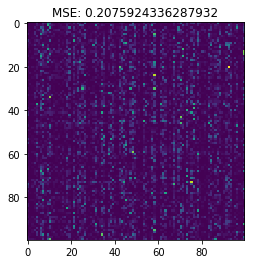

In [14]:
X_pca_rc = X_pca.copy()  # make a copy of the principal component weights
X_pca_rc[:, 50:] = 0  # zero out the weights for the components we don't want
recon_x = pca.inverse_transform(X_pca_rc)
compare_x(x, recon_x)

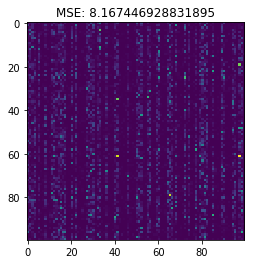

In [15]:
X_pca_rc = X_pca.copy()  # make a copy of the principal component weights
X_pca_rc[:, 1:] = 0  # zero out the weights for the components we don't want
recon_x = pca.inverse_transform(X_pca_rc)
compare_x(x, recon_x)

# Extra

For completeness, ICA is another projection method that maximizes the independence between features rather than the proportion variance explained.

(<matplotlib.figure.Figure at 0x7f01f42fd3c8>,
 <matplotlib.axes._subplots.Axes3DSubplot at 0x7f01f42b0128>)

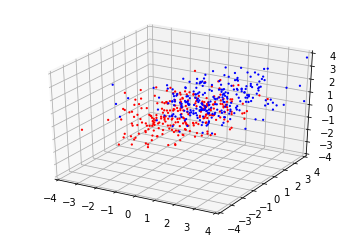

In [16]:
# generate random data. Feel free to modify
n = 250
m1 = np.array([0, 0, 0])
m2 = np.array([1, 1, 1])
cov1 = np.array([[1, .9, .1],
                 [.9, 1, .2],
                 [.1, .2, 1]])
cov2 = cov1 
x, y = create_data_cloud(n, m1, m2, cov1, cov2)
plot3D(x, y)

Text(0.5,1,'Histograms')

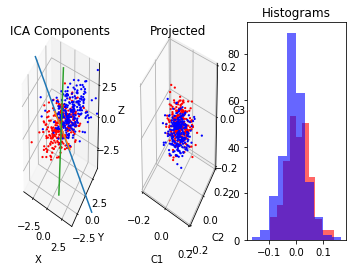

In [17]:
ica = FastICA()
x_ica = ica.fit_transform(x)
f, ax = plot3D(x, y, ica.components_/ica.components_.std(),  
               xc=5, yc=5, zc=5, axloc=131)
ax.set_title('ICA Components')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

f, ax = plot3D(x_ica, y, xc=10, yc=10, zc=10, 
               xlim=[-.2,.2], ylim=[-.2,.2], zlim=[-.2,.2], 
               fig=f, axloc=132)
ax.set_title('Projected')
ax.set_xlabel('C1')
ax.set_ylabel('C2')
ax.set_zlabel('C3')

ax = f.add_subplot(133)
ax.hist(x_ica[y==0, 0], alpha=0.6, color='r')
ax.hist(x_ica[y==1, 0], alpha=0.6, color='b')
ax.set_title("Histograms")